# эксперименты для многокритериальной оптимизациии

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import multiobjective_opt.function_handler as fh
import numpy as np
from jax import grad
from jax import numpy as jnp
from scipy.optimize import minimize

### Online Grad Descent

Рассмотрим случайные квадратичные формы как оптимизируемые функции

Они зависят от тех же параметров, так что будет происходить конкурентная оптимизация

In [3]:
from multiobjective_opt.functions import LinearFunc, QuadForm
from multiobjective_opt.online_optimizers import OnlineGradientDescent
from multiobjective_opt.w_generators import StochasticWGenerator

In [4]:
d = 10
m = 3
T = 400

# определяем функции
functions = [QuadForm(d) for _ in range(m)]
functions = [fh.JaxFunc(f) for f in functions]
vectored_func = fh.stack_functions(functions)


def wXvec(w, x):
    return w @ vectored_func(x)


wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

# определяем генератор
w_generator = StochasticWGenerator(m, T)

# определяем оптимизатор
optimizer = OnlineGradientDescent(wx, w_generator=w_generator, lr_scaler=0.07)

x = np.zeros((d))
res = optimizer.run(x)

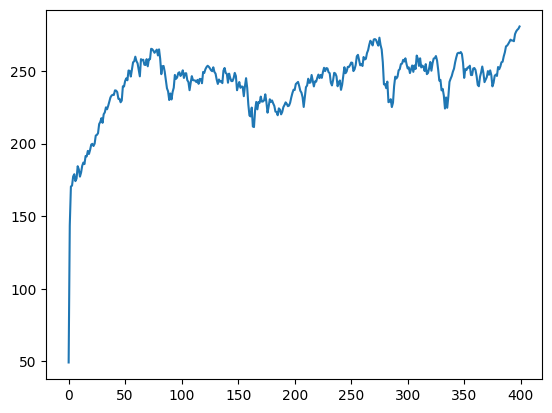

In [5]:
w_exp = np.ones(m, float) / m


def f(x):
    res = w_exp @ vectored_func(x)
    return res


val = minimize(f, np.random.rand(d), jac=grad(f))
minimizer = val.x

regret = [loss - (t + 1) * val.fun for t, loss in enumerate(res.losses)]

plt.plot(regret)

Рассмотрим линейные функции

оптимизируем на множестве $[0,1]^d$

In [6]:
d = 10
m = 3
T = 800

functions = [LinearFunc(d) for _ in range(m)]
vectored_func = fh.stack_functions(functions)


def wXvec(w, x):
    return w @ vectored_func(x)


wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

# определяем генератор
w_generator = StochasticWGenerator(m, T)

# определяем prox function


def projection(x):
    return np.clip(x, 0.0, 1.0)


# определяем оптимизатор
optimizer = OnlineGradientDescent(
    wx, w_generator=w_generator, lr_scaler=0.07, projection_function=projection
)

x = np.zeros((d))
res = optimizer.run(x)

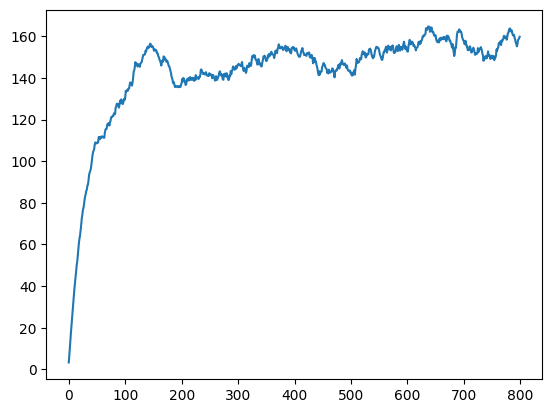

In [7]:
from scipy.optimize import Bounds, minimize


w_exp = np.ones(m, float) / m


def f(x):
    res = w_exp @ vectored_func(x)
    return res


val = minimize(
    f, x0=np.ones(d) * 0.5, bounds=Bounds(np.zeros(d), np.ones(d)), jac=grad(f)
)

minimizer = val.x
regret = [loss - (t + 1) * val.fun for t, loss in enumerate(res.losses)]

plt.plot(regret)

### RFTL

In [107]:
from multiobjective_opt.functions import ModularFunc
from multiobjective_opt.online_optimizers import RFTL
from scipy.optimize import Bounds, minimize


d = 2
m = 5
T = 5_00

functions = [ModularFunc(d) for _ in range(m)]
vectored_func = fh.stack_functions(functions)


def wXvec(w, x):
    return w @ vectored_func(x)


wx = fh.JaxFunc(wXvec, grad_kwargs={"argnums": 1})

bounds = Bounds(-np.ones(d) * 2, np.ones(d) * 2)

from scipy.optimize import Bounds, minimize


w_exp = np.ones(m, float) / m


def f(x):
    res = w_exp @ vectored_func(x)
    return res


val = minimize(f, x0=np.ones(d) * 0.5, bounds=bounds, jac=grad(f))

minimizer = val.x

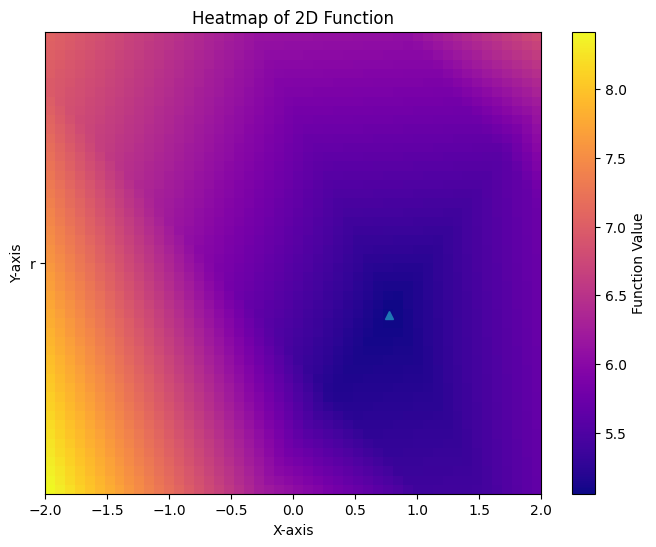

In [108]:
import matplotlib.pyplot as plt

# рисует heatmap
import numpy as np


def generate_heatmap(func, x_range, y_range, resolution=100, cmap="viridis"):
    """
    Рисует heatmap для заданной двумерной функции.

    :param func: Двумерная функция f(x, y)
    :param x_range: Кортеж (x_min, x_max) для диапазона x
    :param y_range: Кортеж (y_min, y_max) для диапазона y
    :param resolution: Разрешение сетки (количество точек по каждой оси)
    :param cmap: Цветовая карта для heatmap
    """
    # Создаем сетку
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((resolution, resolution), dtype=float)
    # Вычисляем значения функции
    min_val = float("inf")
    min_pos = None
    for i in range(resolution):
        for j in range(resolution):
            Z[i][j] = func(X[i][j], Y[i][j])
            if min_val > Z[i][j]:
                min_val = Z[i][j]
                min_pos = (i, j)

    # Создаем heatmap
    plt.figure(figsize=(8, 6))
    plt.imshow(
        Z,
        extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
        origin="lower",
        cmap=cmap,
        aspect="auto",
    )
    plt.colorbar(label="Function Value")

    plt.title("Heatmap of 2D Function")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    # рисуем минимум
    i, j = min_pos
    x, y = X[i][j], Y[i][j]
    plt.plot(x, y, "^", "r")
    plt.show()


# Пример использования


def example_func(x, y):
    return f(np.array([x, y]))


generate_heatmap(
    example_func, x_range=(-2, 2), y_range=(-2, 2), resolution=50, cmap="plasma"
)

In [109]:
# определяем генератор

w_generator = StochasticWGenerator(m, T, seed=1)


# определяем prox function
def projection(x):
    return np.clip(x, 0.0, 1.0)


# определяем оптимизатор
optimizer = RFTL(wx, w_generator=w_generator, eta=0.1, projection_function=projection)

x = np.zeros((d))
res_rftl = optimizer.run(x, bounds=bounds)

500it [00:03, 129.64it/s]


In [110]:
from multiobjective_opt.online_optimizers import RFTL_structured


# определяем генератор

w_generator = StochasticWGenerator(m, T, seed=1)

# определяем prox function


def projection(x):
    return np.clip(x, 0.0, 1.0)


# определяем оптимизатор
optimizer = RFTL_structured(
    wx, w_generator=w_generator, eta=10.0, projection_function=projection
)

x = np.zeros((d))
res_rftl_struct = optimizer.run(x, vectored_func, bounds=bounds)

500it [01:07,  7.36it/s]


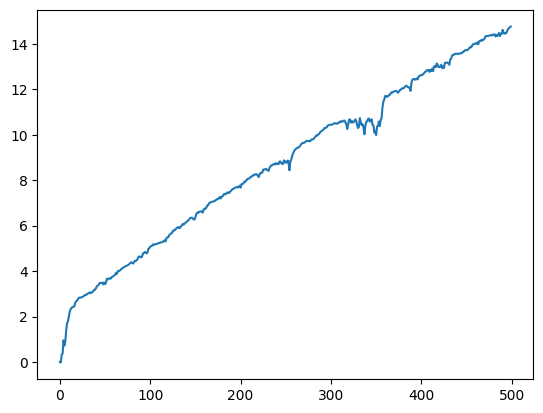

In [111]:
regret_rftl = [loss - (t + 1) * val.fun for t, loss in enumerate(res_rftl.losses)]
regret_rftl_struct = [
    loss - (t + 1) * val.fun for t, loss in enumerate(res_rftl_struct.losses)
]
relative = [
    loss_rf - loss_reg
    for loss_rf, loss_reg in zip(res_rftl.losses, res_rftl_struct.losses)
]
plt.plot(relative)

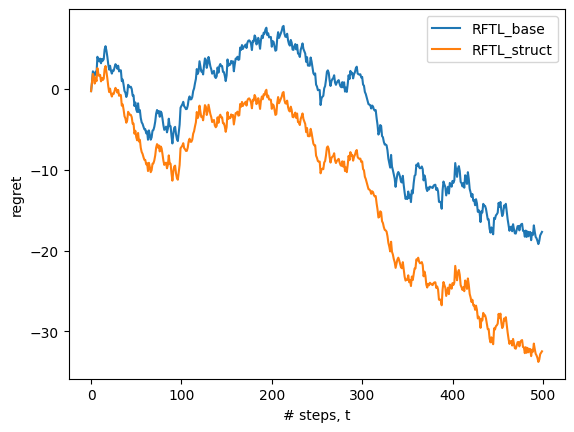

In [112]:
plt.plot(regret_rftl, label="RFTL_base")
plt.plot(regret_rftl_struct, label="RFTL_struct")
plt.xlabel("# steps, t")
plt.ylabel("regret")
plt.legend()

### Online optimizer

In [156]:
from multiobjective_opt.functions import ModularFunc
from multiobjective_opt.online_optimizers import RFTL
from scipy.optimize import Bounds, minimize


d = 3
m = 10
T = 10_00

functions = {i: fh.JaxFunc(ModularFunc(d)) for i in range(m)}

bounds = Bounds(-np.ones(d) * 2, np.ones(d) * 2)


def projection(x):
    return np.clip(x, -2.0, 2.0)


minimas = {
    i: minimize(f, x0=np.ones(d) * 0.5, bounds=bounds, jac=grad(f))
    for i, f in functions.items()
}

In [157]:
4 * (d**0.5)

6.928203230275509

In [172]:
from multiobjective_opt.online_optimizers import BanditGradDescent


G = 3
D = 4 * (d**0.5)
lr_scalers = {i: D / G for i in range(m)}

bound_scalers = {i: D for i in range(m)}

x0 = {
    i: np.random.randn(
        d,
    )
    for i in range(m)
}

bandit_optim = BanditGradDescent(functions, lr_scalers, bound_scalers, projection)

In [159]:
res = bandit_optim.run(x0, T)

2.572819


,$f^*$,$f_i(\overline(x_i)$,$\# pulls$
0,1.070262,1.0749711,537
1,2.281951,2.4795804,81
2,4.128493,4.3903027,24
3,1.544178,1.5737541,221
4,1.669688,2.2637713,99
5,5.439208,6.76425,9
6,4.995376,5.227036,17
7,7.856056,8.799184,5
8,9.400564,9.904781,4
9,10.941243,13.467407,3


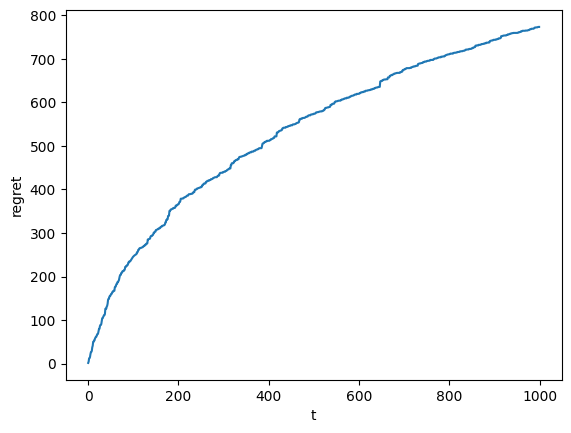

In [168]:
values = {i: lst[-1] for i, lst in res[0].items()}
true_vals = {i: m.fun for i, m in minimas.items()}
arm_pulls = {i: len(lst) for i, lst in res[0].items()}

losses = res[1]
best = min(true_vals.values())
cumulative_best = np.arange(T) * best
regret = np.cumsum(losses) - cumulative_best

import pandas as pd


values, true_vals, arm_pulls


plt.plot(regret)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("t")
plt.ylabel("regret")


table = []
for i in values.keys():
    t_item = [true_vals[i], values[i], arm_pulls[i]]
    table.append(t_item)


pd.DataFrame(table, columns=[r"$f^*$", r"$f_i(\overline(x_i)$", r"$\# pulls$"])

In [227]:
f = fh.JaxFunc(lambda x: jnp.abs(x) + 1)
g = fh.JaxFunc(lambda x: -x * (x < 0) + x**2 * (x > 0))

funcs = {0: f, 1: g}
minimas = {0: 1, 1: 0}
D = 2
G = 1
lr_scalers = {i: D / G for i in range(m)}

bound_scalers = {i: D for i in range(m)}

x0 = {0: np.array(-2.1, float), 1: np.array(-3, float)}

bandit_optim = BanditGradDescent(funcs, lr_scalers, bound_scalers, projection)
res = bandit_optim.run(x0, T)

1


,$f^*$,$f_i(\overline(x_i)$,$\# pulls$
1,0,0.001722,1000


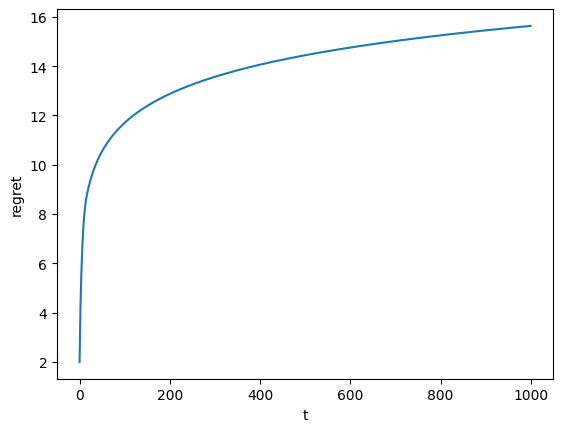

In [228]:
values = {i: lst[-1] for i, lst in res[0].items()}
true_vals = {i: m for i, m in minimas.items()}
arm_pulls = {i: len(lst) for i, lst in res[0].items()}

losses = res[1]
best = min(true_vals.values())
cumulative_best = np.arange(T) * best
regret = np.cumsum(losses) - cumulative_best

import pandas as pd


values, true_vals, arm_pulls


plt.plot(regret)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("t")
plt.ylabel("regret")


table = []
index = []
for i in values.keys():
    t_item = [true_vals[i], values[i], arm_pulls[i]]
    index.append(i)
    table.append(t_item)


pd.DataFrame(
    table, columns=[r"$f^*$", r"$f_i(\overline(x_i)$", r"$\# pulls$"], index=index
)

Text(0, 0.5, 'y')

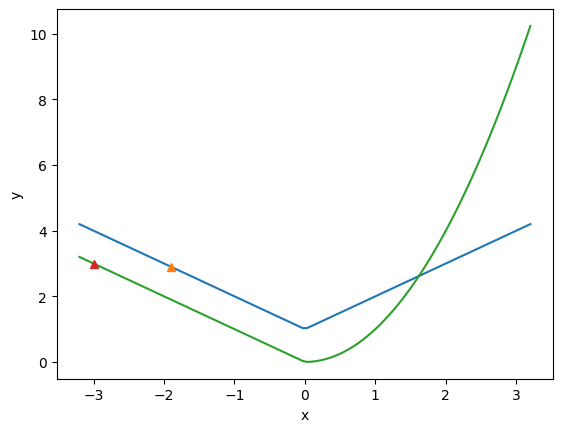

In [226]:
x_s = np.linspace(-3.2, 3.2, 100)
x0 = {0: np.array(-1.9, float), 1: np.array(-3, float)}
for ff, x0_v in zip(funcs.values(), x0.values()):
    y_s = ff(x_s)
    plt.plot(x_s, y_s)
    point = (x0_v, ff(x0_v))
    plt.plot(*point, "^")
plt.xlabel("x")
plt.ylabel("y")

In [222]:
x0

{0: np.float32(0.06324548), 1: array(-3.)}

### train mnist models


In [4]:
from experiments.train import mab_mnist


ucb_res = mab_mnist.main(num_pulls=50)

Init eval:   0%|          | 0/5 [01:09<?, ?it/s]


KeyboardInterrupt: 

In [27]:
from tabulate import tabulate


data = []

for model in ucb_res[0]:
    st = model.statistics
    accuracy = st.eval_results[-1]["accuracy"]
    loss = st.eval_results[-1]["loss"]
    confidence_interval = model.coeff / st.train_steps**0.5
    row = [st.model_name, st.num_pulls, accuracy, loss, confidence_interval]
    data.append(row)
headers = [
    "Model name",
    "model pulls",
    "Model Accuracy",
    "Model loss",
    "Confidence interval",
]
print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model name        ┃   model pulls ┃   Model Accuracy ┃   Model loss ┃   Confidence interval ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━┫
┃ SimpleLinearModel ┃             1 ┃            0.887 ┃        0.419 ┃                 0.516 ┃
┃ MLP               ┃             1 ┃            0.912 ┃        0.305 ┃                 0.488 ┃
┃ Conv1LayerModel   ┃             5 ┃            0.973 ┃        0.091 ┃                 1.996 ┃
┃ Conv2LayerModel   ┃             2 ┃            0.973 ┃        0.088 ┃                 1.777 ┃
┃ GoodMNISTModel    ┃            41 ┃            0.991 ┃        0.032 ┃                 2.123 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━┛


### train cifar model

нужны оценки на G * D

Для этого используем

In [33]:
from experiments.train import mab_cifar, mab_mnist


ucb_res = mab_cifar.main(num_pulls=50)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Total pulls: 100%|██████████| 44/44 [00:45<00:00,  1.04s/it]


In [34]:
from tabulate import tabulate


data = []

for model in ucb_res[0]:
    st = model.statistics
    accuracy = st.eval_results[-1]["accuracy"]
    loss = st.eval_results[-1]["loss"]
    confidence_interval = model.coeff / st.train_steps**0.5
    row = [st.model_name, st.num_pulls, accuracy, loss, confidence_interval]
    data.append(row)
headers = [
    "Model name",
    "model pulls",
    "Model Accuracy",
    "Model loss",
    "Confidence interval",
]
print(tabulate(data, headers=headers, floatfmt=".3f", tablefmt="heavy_outline"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Model name        ┃   model pulls ┃   Model Accuracy ┃   Model loss ┃   Confidence interval ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━┫
┃ SimpleLinearModel ┃             1 ┃            0.365 ┃        1.824 ┃                 1.008 ┃
┃ MLP               ┃             1 ┃            0.413 ┃        1.662 ┃                 1.760 ┃
┃ CNN               ┃             1 ┃            0.477 ┃        1.425 ┃                 2.521 ┃
┃ DeepCNN           ┃             1 ┃            0.463 ┃        1.491 ┃                 1.250 ┃
┃ CNNDropout        ┃             2 ┃            0.525 ┃        1.307 ┃                 2.840 ┃
┃ CNNBatchNorm      ┃            44 ┃            0.716 ┃        1.146 ┃                 2.792 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━┛


In [26]:
coeffs, num_params

({'SimpleLinearModel': 21.76943247742194,
  'FullyConnectedModel': 23.57429783653583,
  'Conv2LayerModel': 22.175572187942556,
  'Conv3LayerModel': 9.472146612858083,
  'ConvDropout': 32.83737871169194,
  'ConvBatchNorm': 185.7990384587649},
 {'SimpleLinearModel': 30730,
  'FullyConnectedModel': 1707274,
  'Conv2LayerModel': 2122186,
  'Conv3LayerModel': 1147466,
  'ConvDropout': 2122186,
  'ConvBatchNorm': 2122378})

In [30]:
for k in coeffs:
    coeff = coeffs[k]
    params = num_params[k]
    print(params / coeff)

3068.3394953366064
97424.09914393559
79617.95937079068
81515.20556141362
47406.69993973048
11724.501513739307


In [ ]:
from experiments.mnist_experiment.dataset_prepare import load_cifar10


iterator_steps = 50
num_pulls = 200

train_loader, test_loader = load_cifar10()

train_loader = funcs.LoaderCycleHandler(train_loader, True, iterator_steps=iterator_steps)
neural_ucb = funcs.UCB_nets(models_list, train_loader, test_loader, coeffs_list)

ucb_res = neural_ucb.ucb_train_models(sum_epochs=num_pulls)

In [1]:
from experiments.utils.dataset_prepare import CIFAR10Handler


train_loader, test_loader = CIFAR10Handler(False).load_dataset()
train_loader = train_loader.get_iterator()

Files already downloaded and verified
Files already downloaded and verified


In [2]:
len(train_loader)

391

len(train_loader)